In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt

import numpy as np

from Load_Data import load_data

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


# Load Data

In [2]:
def get_data_loaders(batch_size=256, faste_files_to_load=37, normalize=False):
    Data = load_data(data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Mean'), 
                     train_val_data_to_load=math.inf,
                     test_data_to_load=math.inf,
                     faste_files_to_load=faste_files_to_load,
                     normalize=normalize)
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader

faste_files_to_load = 37
normalize = False
train_loader, val_loader, test_loader = get_data_loaders(faste_files_to_load=faste_files_to_load, normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste


KeyboardInterrupt: 

# Build Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_kernels=[1024, 512, 256], kernel_size=[512,256,128],
                 dropout=0):
        super(SimpleCNN, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[0], 37),
            nn.ReLU(),  # ReLU ensures positive outputs
            # nn.LogSoftmax(dim=1)  # Apply log softmax if necessary for your task
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

In [ ]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[128, 64, 32, 16], kernel_size=[10,10,10,10],
                 dropout=0, transformer_heads=4, transformer_layers=3):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.transformer_heads=transformer_heads
        self.transformer_layers=transformer_layers
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            #nn.BatchNorm1d(num_features=num_kernels[1]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),        
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
        ))
        # Add a fourth convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    nn.Conv1d(in_channels=self.num_kernels[2],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout),         
        #))

        # the transformer is a combo of multiple encoder layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_kernels[2],
                                       nhead=self.transformer_heads,
                                       dim_feedforward=num_kernels[2]*2),
                                       self.transformer_layers)
        self.attention_weights = None  # Store attention weights
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[2], faste_files_to_load),
            nn.ReLU(),  # ReLU ensures positive outputs
        ) 

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)  
       #x = self.transformer(x)      
        x = self.regression_block(x)
        return x

In [ ]:
class DNATranformer(nn.Module):
    def __init__(self, num_kernels=[128, 64, 32, 16], kernel_size=[10,10,10,10],
                 dropout=0, transformer_heads=4, transformer_layers=3):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.transformer_heads=transformer_heads
        self.transformer_layers=transformer_layers
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            #nn.BatchNorm1d(num_features=num_kernels[1]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),        
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
        ))

        # the transformer is a combo of multiple encoder layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_kernels[2],
                                       nhead=self.transformer_heads,
                                       dim_feedforward=num_kernels[2]*2),
                                       self.transformer_layers)


        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[2], faste_files_to_load),
            nn.ReLU(),  # ReLU ensures positive outputs
        ) 

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)  
        x = self.transformer(x)      
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patience=10):
    p = patience

    train_loss = []
    validation_loss = []
    best_loss = math.inf
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if train_loss[-1] < validation_loss[-1]:
            # print(f"Training loss {train_loss[-1]} is less than validation loss {validation_loss[-1]}")

            if train_loss[-1]/validation_loss[-1] < 0.5:
                print(f"Training loss {train_loss[-1]} is less than half of validation loss {validation_loss[-1]}")
                p -= 1
                
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(save_dir, 'loss.png'), dpi=300)
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

/home/formanj/miniconda3/envs/ImgProc_GPU_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0
-------------------------------
training loss: 2.764114
Validation Loss: 2.122143 

Epoch 10
-------------------------------
training loss: 2.728550
Validation Loss: 2.111420 

Epoch 20
-------------------------------
training loss: 2.678674
Validation Loss: 2.067864 

Epoch 30
-------------------------------
training loss: 2.619530
Validation Loss: 2.030478 

Epoch 40
-------------------------------
training loss: 2.566062
Validation Loss: 2.006709 

Epoch 50
-------------------------------
training loss: 2.532965
Validation Loss: 1.986129 

Epoch 60
-------------------------------
training loss: 2.492944
Validation Loss: 1.974669 

Epoch 70
-------------------------------
training loss: 2.475691
Validation Loss: 1.968789 

Epoch 80
-------------------------------
training loss: 2.452559
Validation Loss: 1.978708 

Epoch 90
-------------------------------
training loss: 2.418309
Validation Loss: 1.955231 

Done!


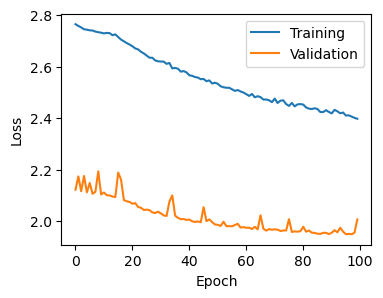

In [ ]:
save_dir = os.path.join(os.getcwd(), 'Model_DNATranformer')
os.makedirs(save_dir, exist_ok=True)


num_kernels=[128, 64, 32, 16]
# num_kernels=[32,16,8]
kernel_size=[10,10,10,10]
dropout=0.1
transformer_heads=4
transformer_layers=3
lr = 0.0001
faste_files_to_load=37

model = DNATranformer(num_kernels=num_kernels,
                    kernel_size=kernel_size,
                    dropout=dropout,
                    transformer_heads=transformer_heads,
                    transformer_layers=transformer_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
train_model(train_loader, val_loader, model, optimizer, loss_fn, 500, save_dir, 10)

### Save Model

In [ ]:
torch.save(model, os.path.join(save_dir, 'model.pth'))

### Validate Model

In [ ]:
model = torch.load(os.path.join(save_dir, 'model.pth'), weights_only=False)
model.to(device)
model.eval()

In [ ]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = model.forward(X).to(device)
#y_pred = torch.exp(y_pred)

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)
print(loss_fn(y_pred, y))

In [ ]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            y_pred = torch.exp(model(X))
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)

            #y_pred = y_pred.cpu().detach().numpy().reshape(output.shape[0])
            #labels=target.cpu().numpy().reshape(output.shape[0])
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.savefig(os.path.join(save_dir, 'Accuracy.pth'), dpi=300)
plt.show()